In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Fitting 3 folds for each of 72 candidates, totalling 216 fits
✅ Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
🎯 Best Accuracy Score (CV): 0.9174950484826297
⏱️ Time Taken: 316.05 sec

📊 Classification Report:
               precision    recall  f1-score   support

     anxious       1.00      0.95      0.97        37
  dependency       1.00      0.98      0.99        43
  exhaustion       1.00      0.95      0.98        42
       guilt       0.83      1.00      0.90        38
      reward       0.97      0.90      0.94        40

    accuracy                           0.95       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.95      0.96       200



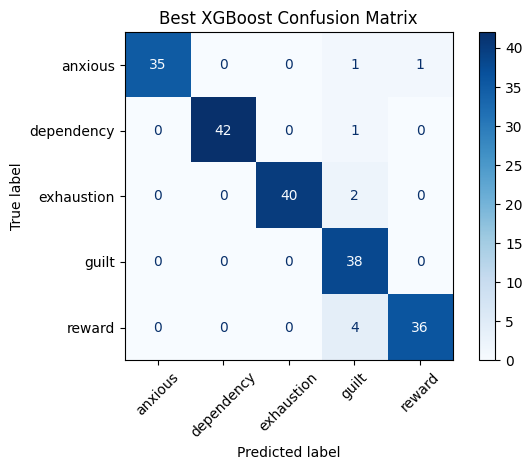

✅ Model and preprocessors saved!


In [41]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from xgboost import XGBClassifier

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/AI-Powered-Anti-Short-Video-Addiction-Assistant/short_video_behavior_dataset.csv")

# Encode target label
le = LabelEncoder()
df['psych_state_label_encoded'] = le.fit_transform(df['psych_state_label'])

# Clean & extract features
df['content_type_keywords'] = df['content_type_keywords'].apply(lambda x: ' '.join(eval(x)) if isinstance(x, str) else '')
X = df.drop(columns=['user_id', 'psych_state_label', 'self_reported_goal', 'psych_state_label_encoded'])
y = df['psych_state_label_encoded']

# Separate text and other features
text_col = 'content_type_keywords'
text_data = X[text_col]
X = X.drop(columns=[text_col])
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['bool', 'object']).columns.tolist()

# TF-IDF vectorizer for text
tfidf = TfidfVectorizer(max_features=50)
X_tfidf = pd.DataFrame(tfidf.fit_transform(text_data).toarray(), columns=tfidf.get_feature_names_out())

# One-hot encoding for categorical
X_cat = pd.get_dummies(X[categorical_cols], drop_first=True)

# Scale numeric features
scaler = StandardScaler()
X_num = pd.DataFrame(scaler.fit_transform(X[numeric_cols]), columns=numeric_cols)

# Combine all features
X_final = pd.concat([X_num.reset_index(drop=True), X_cat.reset_index(drop=True), X_tfidf.reset_index(drop=True)], axis=1)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, stratify=y, random_state=42)

# Grid Search for XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=3,
                           verbose=1,
                           n_jobs=-1)

start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

print("✅ Best Parameters:", grid_search.best_params_)
print("🎯 Best Accuracy Score (CV):", grid_search.best_score_)
print("⏱️ Time Taken: {:.2f} sec".format(end_time - start_time))

# Best model
best_model = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_model.predict(X_test)
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=le.classes_, cmap='Blues')
plt.title("Best XGBoost Confusion Matrix")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save everything
joblib.dump(best_model, 'xgboost_best_model.pkl')
joblib.dump(le, 'label_encoder.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("✅ Model and preprocessors saved!")


In [42]:
import joblib

# Save trained model
joblib.dump(best_model, 'xgboost_best_model.pkl')

# Save label encoder
joblib.dump(le, 'label_encoder.pkl')

# Save scaler and tfidf
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

print("✅ All model components saved!")


✅ All model components saved!


In [43]:
import joblib
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# 🔄 Load saved components
model = joblib.load('xgboost_best_model.pkl')
scaler = joblib.load('scaler.pkl')
tfidf = joblib.load('tfidf_vectorizer.pkl')
le = joblib.load('label_encoder.pkl')

# 🆕 Example user input (can be from API/form)
new_user = {
    "session_duration_min": 52.3,
    "active_period_label": "late_night",
    "avg_video_duration_sec": 37.2,
    "switch_frequency": 2.6,
    "content_emotion_score": -0.54,
    "content_type_keywords": ["ai", "study", "focus"],
    "repeated_viewing_ratio": 0.21,
    "skipped_intro_ratio": 0.52,
    "saved_to_favorites": False,
    "3_day_total_watch_time": 465.2,
    "short_video_ratio": 0.89
}

# 🧹 Preprocess the input
df_input = pd.DataFrame([new_user])
df_input['content_type_keywords'] = df_input['content_type_keywords'].apply(lambda x: ' '.join(x))

# Separate features
text = df_input['content_type_keywords']
X_tfidf = pd.DataFrame(tfidf.transform(text).toarray(), columns=tfidf.get_feature_names_out())

numeric_cols = [
    "session_duration_min", "avg_video_duration_sec", "switch_frequency",
    "content_emotion_score", "repeated_viewing_ratio", "skipped_intro_ratio",
    "3_day_total_watch_time", "short_video_ratio"
]
X_num = pd.DataFrame(scaler.transform(df_input[numeric_cols]), columns=numeric_cols)

X_cat = pd.get_dummies(df_input[['active_period_label', 'saved_to_favorites']], drop_first=True)

# Align dummy columns with training set (in case of category mismatch)
# Recreate column set from training (optional: save it during training for consistency)
expected_cols = list(model.get_booster().feature_names)
X_all = pd.concat([X_num.reset_index(drop=True), X_cat.reset_index(drop=True), X_tfidf.reset_index(drop=True)], axis=1)
X_all = X_all.reindex(columns=expected_cols, fill_value=0)

# 🎯 Predict
pred = model.predict(X_all)
predicted_label = le.inverse_transform(pred)[0]
print("🧠 Predicted Psychological State:", predicted_label)


🧠 Predicted Psychological State: guilt


In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
import pandas as pd
import joblib

# Load model and preprocessors
model = joblib.load('xgboost_best_model.pkl')
scaler = joblib.load('scaler.pkl')
tfidf = joblib.load('tfidf_vectorizer.pkl')
label_encoder = joblib.load('label_encoder.pkl')

app = FastAPI(title="Psychological State Predictor")

# Define expected input format
class UserInput(BaseModel):
    session_duration_min: float
    active_period_label: str
    avg_video_duration_sec: float
    switch_frequency: float
    content_emotion_score: float
    content_type_keywords: list
    repeated_viewing_ratio: float
    skipped_intro_ratio: float
    saved_to_favorites: bool
    three_day_total_watch_time: float
    short_video_ratio: float

@app.post("/predict")
def predict_state(user: UserInput):
    # Convert input to DataFrame
    data = pd.DataFrame([user.dict()])

    # Prepare columns
    data['content_type_keywords'] = data['content_type_keywords'].apply(lambda x: ' '.join(x))

    # Text feature
    tfidf_features = pd.DataFrame(tfidf.transform(data['content_type_keywords']).toarray(), columns=tfidf.get_feature_names_out())

    # Numeric features
    numeric_cols = [
        'session_duration_min', 'avg_video_duration_sec', 'switch_frequency',
        'content_emotion_score', 'repeated_viewing_ratio', 'skipped_intro_ratio',
        'three_day_total_watch_time', 'short_video_ratio'
    ]
    scaled_num = pd.DataFrame(scaler.transform(data[numeric_cols]), columns=numeric_cols)

    # Categorical features
    cat_data = pd.get_dummies(data[['active_period_label', 'saved_to_favorites']], drop_first=True)

    # Combine all
    final_input = pd.concat([scaled_num.reset_index(drop=True), cat_data.reset_index(drop=True), tfidf_features.reset_index(drop=True)], axis=1)

    # Align columns
    expected_cols = model.get_booster().feature_names
    final_input = final_input.reindex(columns=expected_cols, fill_value=0)

    # Predict
    prediction = model.predict(final_input)
    label = label_encoder.inverse_transform(prediction)[0]

    return {"predicted_state": label}


In [45]:
from google.colab import files

files.download('xgboost_best_model.pkl')
files.download('scaler.pkl')
files.download('tfidf_vectorizer.pkl')
files.download('label_encoder.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>